## 0. Init

In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

sys.path.append("../../")

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from choice_learn.basket_models.self_attention_model import SelfAttentionModel


2025-11-03 14:19:25.367875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-03 14:19:25.379110: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-03 14:19:25.382565: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-03 14:19:25.392459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-03 14:19:25.974791: W tensorflow/compiler/tf2

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


2025-11-03 14:19:27.082556: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-11-03 14:19:27.082581: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: research-Lambda-Vector
2025-11-03 14:19:27.082587: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: research-Lambda-Vector
2025-11-03 14:19:27.082667: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 535.274.2
2025-11-03 14:19:27.082686: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 535.230.2
2025-11-03 14:19:27.082692: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:252] kernel version 535.230.2 does not match DSO version 535.274.2 -- cannot find working devices in this configuration


## I.  Synthetic Dataset

Dataset We build a synthetic dataset for which the catalog has 8 items, I=
{1,...,8}, with the following interactions:
- Cannibalization: {0,1, 2} on the one hand and {3,4,5} on the other hand
form groups of items cannibalizing each other.
- Complementarity: each of the items in {0,1,2} are complementary to each
of the items in {3,4,5};
- Neutral: 6, 7 and 8 are neutral in the sense that they don’t have specific
interaction with other items.
- When choosing among the first nest, user 0 prefers item 0, user 1 the item 1 and user 2 the item 2.

In [4]:
from choice_learn.basket_models.data.synthetic_dataset import SyntheticDataGenerator

"""items_nest : dict
                Dictionary defining item sets and their relations.
                Key should be next index and values list of items indexes, e.g."""

items_nest = { 0:[0, 1,2],
                1: [3,4,5],
                2: [6,7,8]}

"""nests_interactions: list
                List of interactions between nests for each nest. Symmetry should
                be ensure by users, e.g."""
                
nests_interactions = [["", "compl", "neutral", "neutral"],
                    ["compl", "", "neutral", "neutral"],
                    ["neutral", "neutral", "", "neutral"]]
    
""" proba_complementary_items : float
        Probability of adding complementary items to the basket.
    proba_neutral_items : float
        Probability of adding neutral items to the basket.
    noise_proba : float
        Probability of adding noise items to the basket."""

user_profile = {0:{ "nest" : 0, "item" : 0}, 1: {"nest" : 0, "item" : 1}, 2: {"nest" : 0, "item" : 2}}

"""user_profile : dict
                Dictionary defining user profiles.
                Key should be user index and values a dict with 'nest' and 'item' keys"""

data = SyntheticDataGenerator(items_nest=items_nest,
                       nests_interactions=nests_interactions,
                       proba_complementary_items=1,
                       proba_neutral_items=0.0,
                       noise_proba=0.0,
                       user_profile=user_profile,
                       nb_users=3)

data = data.generate_trip_dataset(n_baskets=1000, assortments_matrix=np.ones((1, 9)))

data.available_items

array([[1., 1., 1., 1., 1., 1., 1., 1., 1.]])

## II. Self Attention Model

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

lr = 0.005
n_epochs = 20
batch_size = 32
latent_sizes = {"short_term": 2, "long_term": 2}
L = 7
gamma = 0.7
w = 0.3
n_negative_samples = 1
optimizer = "adam"
λ = 0.0
dropout_rate = 0.0



In [6]:
model = SelfAttentionModel(
    optimizer=optimizer,
    n_negative_samples=n_negative_samples,
    lr=lr,
    epochs=n_epochs,
    batch_size=batch_size,
    latent_sizes=latent_sizes,
    L=L,
    gamma=gamma,
    w=w,
    lambd=λ,
    dropout_rate=dropout_rate,
   
)

model.instantiate(n_items=data.n_items, n_users=data.n_users)

In [7]:
history = model.fit(trip_dataset=data, verbose=2)

Epoch 0 Train Loss 0.9686:   5%|▌         | 1/20 [00:04<01:22,  4.32s/it]

Loop 0 Time: 4.3197 Loss: 0.9686


Epoch 1 Train Loss 0.6998:  10%|█         | 2/20 [00:04<00:33,  1.87s/it]

Loop 1 Time: 0.1585 Loss: 0.6998


Epoch 2 Train Loss 0.5366:  15%|█▌        | 3/20 [00:04<00:18,  1.10s/it]

Loop 2 Time: 0.1782 Loss: 0.5366


Epoch 3 Train Loss 0.4072:  20%|██        | 4/20 [00:04<00:11,  1.34it/s]

Loop 3 Time: 0.1969 Loss: 0.4072


Epoch 4 Train Loss 0.3656:  25%|██▌       | 5/20 [00:05<00:08,  1.84it/s]

Loop 4 Time: 0.1869 Loss: 0.3656


Epoch 5 Train Loss 0.3607:  30%|███       | 6/20 [00:05<00:05,  2.35it/s]

Loop 5 Time: 0.1963 Loss: 0.3607


Epoch 6 Train Loss 0.3486:  35%|███▌      | 7/20 [00:05<00:04,  2.83it/s]

Loop 6 Time: 0.2011 Loss: 0.3486


Epoch 7 Train Loss 0.3643:  40%|████      | 8/20 [00:05<00:03,  3.28it/s]

Loop 7 Time: 0.2020 Loss: 0.3643


Epoch 8 Train Loss 0.3555:  40%|████      | 8/20 [00:05<00:03,  3.28it/s]

Loop 8 Time: 0.1980 Loss: 0.3555


Epoch 9 Train Loss 0.3631:  50%|█████     | 10/20 [00:06<00:02,  4.10it/s]

Loop 9 Time: 0.1804 Loss: 0.3631


Epoch 10 Train Loss 0.3541:  55%|█████▌    | 11/20 [00:06<00:02,  4.46it/s]

Loop 10 Time: 0.1772 Loss: 0.3541


Epoch 11 Train Loss 0.3493:  60%|██████    | 12/20 [00:06<00:01,  4.72it/s]

Loop 11 Time: 0.1826 Loss: 0.3493


Epoch 12 Train Loss 0.3516:  65%|██████▌   | 13/20 [00:06<00:01,  4.86it/s]

Loop 12 Time: 0.1912 Loss: 0.3516


Epoch 13 Train Loss 0.3519:  70%|███████   | 14/20 [00:06<00:01,  5.06it/s]

Loop 13 Time: 0.1778 Loss: 0.3519


Epoch 14 Train Loss 0.3542:  75%|███████▌  | 15/20 [00:06<00:00,  5.17it/s]

Loop 14 Time: 0.1827 Loss: 0.3542


Epoch 15 Train Loss 0.3578:  80%|████████  | 16/20 [00:07<00:00,  5.21it/s]

Loop 15 Time: 0.1866 Loss: 0.3578


Epoch 16 Train Loss 0.3538:  85%|████████▌ | 17/20 [00:07<00:00,  5.17it/s]

Loop 16 Time: 0.1965 Loss: 0.3538


Epoch 17 Train Loss 0.3381:  90%|█████████ | 18/20 [00:07<00:00,  5.28it/s]

Loop 17 Time: 0.1784 Loss: 0.3381


Epoch 18 Train Loss 0.3381:  95%|█████████▌| 19/20 [00:07<00:00,  5.29it/s]

Loop 18 Time: 0.1875 Loss: 0.3381


Epoch 19 Train Loss 0.3439: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]

Loop 19 Time: 0.1825 Loss: 0.3439


/tmp/ipykernel_3082358/947846572.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


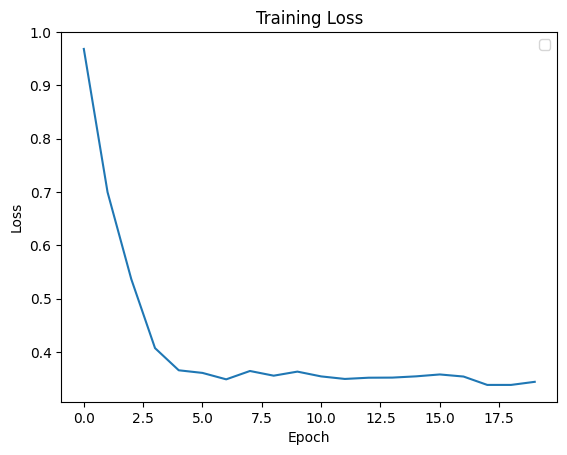

In [8]:
plt.plot(history["train_loss"])
plt.plot(history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")



plt.show()

## III. Embedding Visualisation

In [9]:
X = model.X
U = model.U
V = model.V
d = model.d_long

In [10]:
V

<tf.Variable 'V:0' shape=(9, 2) dtype=float32, numpy=
array([[ 0.722888  , -0.69096494],
       [ 0.36380434,  0.93147534],
       [-0.92509747, -0.37972936],
       [ 0.12565416,  0.18798889],
       [-0.2670058 , -0.19921647],
       [ 0.20025302, -0.274537  ],
       [-0.03358316, -0.03651338],
       [ 0.02711154, -0.04246521],
       [ 0.04225081, -0.13828416]], dtype=float32)>

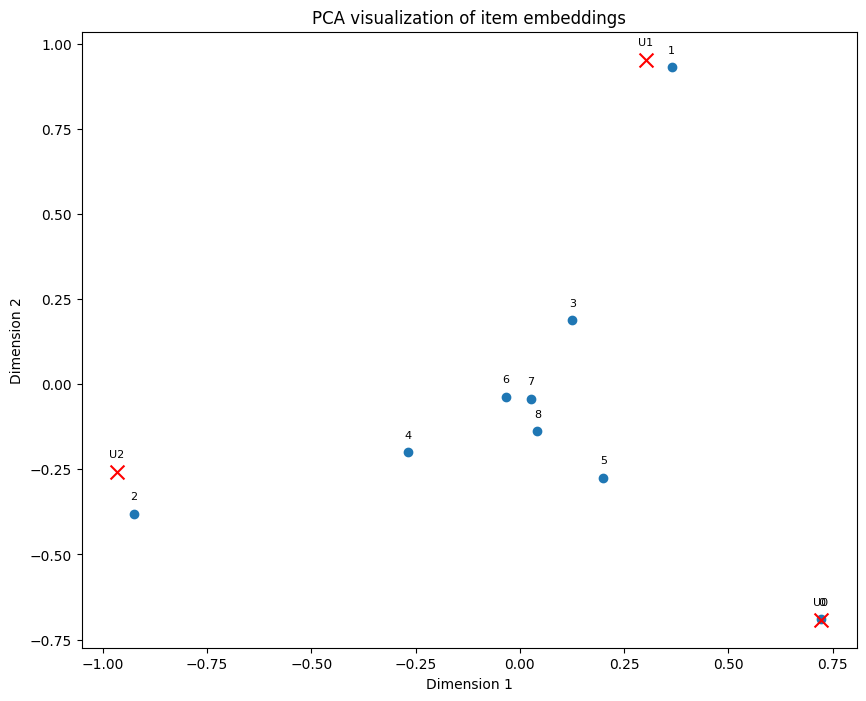

<Axes: >

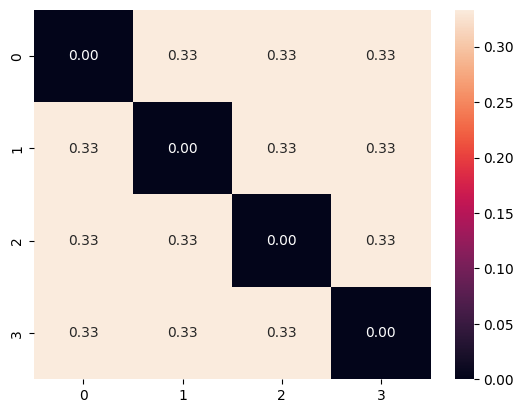

In [13]:
from sklearn.decomposition import PCA
import seaborn as sns

embedding = model.V
basket_batch = [[0,1,3,7]]
m_batch, affinity_matrix = model.embed_context(basket_batch, is_training=False)


if d ==1:
    embedding = np.hstack([embedding, np.zeros((embedding.shape[0],1))])
    U = tf.concat([U, tf.zeros((U.shape[0],1))], axis=1)

if d > 2:
    pca = PCA(n_components=2)
    V_pca = pca.fit_transform(embedding)
    U_pca = pca.transform(U.numpy())
else:
    V_pca = embedding
    U_pca = U.numpy()
plt.figure(figsize=(10, 8))
plt.scatter(V_pca[:, 0], V_pca[:, 1])#, c=color_group)

plt.scatter(U_pca[:,0], U_pca[:,1], color='red', marker='x', s=100, label='User 0')

for i in range(V_pca.shape[0]):
    plt.annotate(str(i), (V_pca[i, 0], V_pca[i, 1]+0.05), 
                     fontsize=8, ha='center', va='center')
for i in range(U_pca.shape[0]):
    plt.annotate(f'U{i}', (U_pca[i, 0], U_pca[i, 1]+0.05), 
                     fontsize=8, ha='center', va='center')

plt.title("PCA visualization of item embeddings")
plt.axis()
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


sns.heatmap(affinity_matrix[0],
            annot=True,     
            fmt='.2f',
            ) 

